# **LR vs MLP**
2023-01-27

Model & Trainer

모델의 학습 Process
1. Initilaize Dataset and DataLoader
2. Initialize Model
3. Train Model

Mnist dataset을 활용한 logistic regression model과 MLP model의 성능 비교 및 파이프라인 학습

# 1. Import packages

In [1]:
import torch
import torch.nn as nn
print(torch.__version__)
print(torch.cuda.is_available())

1.13.1+cu116
True


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

# 2. Preprocess Dataset


## Load Dataset

In [3]:
mnist = fetch_openml('mnist_784', cache=False)

In [4]:
mnist.data.shape

(70000, 784)

## Preprocess Dataset

Mnist Dataset의 image는 각각 28*28의 픽셀로 구성된 784차원 짜리 벡터로 나타나져 있다. 각 픽셀은 0-255사이의 값으로 흰색부터 검은색 사이의 값을 나타낸다.

In [5]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')
X = X.values
y = y.values
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


값이 너무 커지는 것을 방지하기 위해 [0,255]사이의 input을 [0,1]의 scale로 조정

In [7]:
X /= 255.0

In [9]:
print(X.min(), X.max())

0.0 1.0


## Split Train/Test Dataset


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)
print(X_train.shape) # 80%
print(y_train.shape)
print(X_val.shape) # 10%
print(y_val.shape)
print(X_test.shape) # 10%
print(y_test.shape)

(56000, 784)
(56000,)
(7000, 784)
(7000,)
(7000, 784)
(7000,)


## Visualize Dataset

In [35]:
import math

cnt = 1
for i in X[0]:
  if cnt > 28:
    cnt = 1
    print()
  if math.ceil(float(i)) == 0:
    print('■', end='')
  else:
    print('□', end='')
  cnt+=1

■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■□□□□□□□□□□□□■■■■
■■■■■■■■□□□□□□□□□□□□□□□□■■■■
■■■■■■■□□□□□□□□□□□□□□□□■■■■■
■■■■■■■□□□□□□□□□□□■■■■■■■■■■
■■■■■■■■□□□□□□□■□□■■■■■■■■■■
■■■■■■■■■□□□□□■■■■■■■■■■■■■■
■■■■■■■■■■■□□□□■■■■■■■■■■■■■
■■■■■■■■■■■□□□□■■■■■■■■■■■■■
■■■■■■■■■■■■□□□□□□■■■■■■■■■■
■■■■■■■■■■■■■□□□□□□■■■■■■■■■
■■■■■■■■■■■■■■□□□□□□■■■■■■■■
■■■■■■■■■■■■■■■□□□□□■■■■■■■■
■■■■■■■■■■■■■■■■■□□□□■■■■■■■
■■■■■■■■■■■■■■□□□□□□□■■■■■■■
■■■■■■■■■■■■□□□□□□□□■■■■■■■■
■■■■■■■■■■□□□□□□□□□■■■■■■■■■
■■■■■■■■□□□□□□□□□□■■■■■■■■■■
■■■■■■□□□□□□□□□□■■■■■■■■■■■■
■■■■□□□□□□□□□□■■■■■■■■■■■■■■
■■■■□□□□□□□□■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■

In [36]:
X[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [37]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

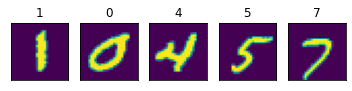

In [38]:
plot_example(X_train, y_train)

# 3. Pytorch Dataset 

PyTorch에서는 Custom Dataset을 사용하기 위해서는 torch.utils.data.Dataset의 형태로 dataset class를 정의해준 이후, torch.utils.data.DataLoader의 형태로 dataloader class를 정의하여 학습시에 model에 forwarding할 data를 sample 해주어야 한다.

(https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)

## Dataset

가장 보편적으로 사용되는 map-style의 dataset class는 torch.utils.data.Dataset을 superclass로 받아 __getitem__()과 __len__()함수를 override해준다.

```
class CustomDataset(torch.utils.data.Dataset):
  def __init__(self, data):
    self.data = data
  
  def __getitem__(self, index):
    return self.data[index]

  def __len__(self):
    return len(self.data)
```

In [39]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super(CustomDataset, self).__init__()
        self.X = X
        self.y = y
        
    def __getitem__(self, index):
        x = self.X[index]
        y = self.y[index]
        x = torch.from_numpy(x).float()
        y = torch.from_numpy(np.array(y)).long()
        return x, y

    def __len__(self):
        return len(self.X)

In [40]:
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

print(len(train_dataset))
print(train_dataset.X.shape)
print(len(val_dataset))
print(val_dataset.X.shape)
print(len(test_dataset))
print(test_dataset.X.shape)

56000
(56000, 784)
7000
(7000, 784)
7000
(7000, 784)


## DataLoader

DataLoader는 train 혹은 validation시 dataset에서 batch를 sampling하기 위한 API다. (https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

필수적으로 사용하는 option
- dataset: sampling할 dataset
- batch_size: 한번에 sampling할 dataset의 개수
- shuffle: 1 epoch를 기준으로 dataset을 shuffle할지

In [41]:
batch_size = 64

# shuffle the train data
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# do not shuffle the val & test data
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# dataset size // batch_size
print(len(train_dataloader))
print(len(val_dataloader))
print(len(test_dataloader))

875
110
110


# 4. Model


Pytorch에서 model을 선언할 때는 torch.nn.Module class를 superclass로 받아 __init__()함수와 forward() 함수를 작성한다.

__init__()함수에는 모델의 파라미터들을 선언하고, forward함수에는 해당 파라미터들을 이용하여 data를 model에 통과시킨다.

https://pytorch.org/docs/stable/generated/torch.nn.Module.html

## Initialize Logistic Regression Model

In [42]:
class LR(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LR, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.fc(x)
        return x

## Initialize MLP Model

In [43]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# 5. Train

이제 선언한 model을 통해 학습을 진행하기 위해서는 model의 파라미터를 최적화할 optimizer가 필요하다. 가장 보편적으로 사용되는 `Adam`을 사용한다.

### Trainer

In [44]:
class Trainer():
    def __init__(self, trainloader, valloader, testloader, model, optimizer, criterion, device):
        """
        trainloader: train data's loader
        testloader: test data's loader
        model: model to train
        optimizer: optimizer to update your model
        criterion: loss function
        """
        self.trainloader = trainloader
        self.valloader = valloader
        self.testloader = testloader
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        
    def train(self, epoch = 1):
        # 학습을 시작할 때 model을 train-mode로 바꿔주어야함.
        self.model.train()
        for e in range(epoch):
            running_loss = 0.0  
            for i, data in enumerate(self.trainloader, 0): 
                inputs, labels = data 
                # model에 input으로 tensor를 gpu-device로 보낸다
                inputs = inputs.to(self.device)  
                labels = labels.to(self.device)
                # zero the parameter gradients -> pytorch에는 미분한 값들이 누적되는 특징이 있기 때문
                self.optimizer.zero_grad()    
                # forward + backward + optimize
                # get output after passing through the network
                outputs = self.model(inputs) 
                # compute model's score using the loss function
                loss = self.criterion(outputs, labels)  
                # perform back-propagation from the loss
                loss.backward() 
                # gradient descent를 통해 model의 output을 얻는다.
                self.optimizer.step() 
                running_loss += loss.item()
            
            print('epoch: %d  loss: %.3f' % (e + 1, running_loss / len(self.trainloader)))
            running_loss = 0.0
        val_acc = self.validate()
        return val_acc

    def validate(self):
        self.model.eval() 
        correct = 0
        for inputs, labels in self.valloader:
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)
            output = self.model(inputs) 
            pred = output.max(1, keepdim=True)[1] # get the index of the max 
            correct += pred.eq(labels.view_as(pred)).sum().item()
        return correct / len(self.valloader.dataset)
        
    def test(self):
        self.model.eval() 
        correct = 0
        for inputs, labels in self.testloader:
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)
            output = self.model(inputs) 
            pred = output.max(1, keepdim=True)[1] # get the index of the max 
            correct += pred.eq(labels.view_as(pred)).sum().item()
        return correct / len(self.testloader.dataset)


## training-mode & eval-mode

nn.Module에는 train time과 evaluate time에 수행하는 다른 작업을 switching해줄 수 있도록하는 함수를 제공한다.

train 단계는 말 그대로 모델을 학습시킨다. 그 말은 validation과 test 단계에서는 학습이 일어나지 않는다는 것이다. (training은 optimizer.step())

같은 epoch에서 train이 되었다면 곧바로 validation을 해주어야 한다. 검증의 최종 목적은 최적의 epoch를 찾아 overfitting과 unseen data 문제를 막는 것이므로 검증용 데이터를 모델에 넣어 loss 함수를 확인해 training의 적합 여부를 판단한다.

test는 validation step과 같으나 loss를 MAE와 같은 함수를 사용한다.

train time과 evaluate time에 서로 다르게 동작해야 하는 것들에는 대표적으로 아래와 같은 것들이 있다.

- `Dropout layer`
- `BatchNorm layer`

model.eval()을 수행하면 evaluation과정에서 사용하지 않을 layer들의 전원을 끈다.

``` python
# eval mode

model.eval()

with torch.no_grad():
	...
    out = model(val_data)
    ...
```
evaluation이 끝나면 다시 train mode로 변경을 해줘야한다.
``` python
# train mode

model.train()
```

## Logistic Regression

In [45]:
input_dim = 784
output_dim = 10
epoch = 4
device = torch.device('cuda')

best_acc = 0.0
lrs = [1e-1, 1e-2, 1e-3, 1e-4]
for lr in lrs:
    model = LR(input_dim=input_dim, output_dim=output_dim).to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    trainer = Trainer(train_dataloader, val_dataloader, test_dataloader, model, optimizer, criterion, device)
    val_acc = trainer.train(epoch = epoch)
    print('val_acc: %.3f' %(val_acc))
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), './best_model')

trainer.model.load_state_dict(torch.load('./best_model'))
test_acc = trainer.test()
print('test_acc: %.3f' %(test_acc))

epoch: 1  loss: 1.161
epoch: 2  loss: 1.173
epoch: 3  loss: 1.269
epoch: 4  loss: 1.315
val_acc: 0.901
epoch: 1  loss: 0.356
epoch: 2  loss: 0.301
epoch: 3  loss: 0.294
epoch: 4  loss: 0.291
val_acc: 0.916
epoch: 1  loss: 0.552
epoch: 2  loss: 0.322
epoch: 3  loss: 0.293
epoch: 4  loss: 0.279
val_acc: 0.921
epoch: 1  loss: 1.401
epoch: 2  loss: 0.738
epoch: 3  loss: 0.557
epoch: 4  loss: 0.473
val_acc: 0.890
test_acc: 0.919


## MLP

In [46]:
input_dim = 784
hidden_dim = 32
output_dim = 10
epoch = 4
device = torch.device('cuda')

best_acc = 0.0
lrs = [1e-1, 1e-2, 1e-3, 1e-4]
for lr in lrs:
    model = MLP(input_dim=input_dim, 
                hidden_dim=hidden_dim,
                output_dim=output_dim).to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    trainer = Trainer(train_dataloader, val_dataloader, test_dataloader, model, optimizer, criterion, device)
    val_acc = trainer.train(epoch = epoch)
    print('val_acc: %.3f' %(val_acc))
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), './best_model')

trainer.model.load_state_dict(torch.load('./best_model'))
test_acc = trainer.test()
print('test_acc: %.3f' %(test_acc))

epoch: 1  loss: 0.861
epoch: 2  loss: 0.835
epoch: 3  loss: 0.897
epoch: 4  loss: 0.939
val_acc: 0.708
epoch: 1  loss: 0.276
epoch: 2  loss: 0.170
epoch: 3  loss: 0.145
epoch: 4  loss: 0.128
val_acc: 0.949
epoch: 1  loss: 0.469
epoch: 2  loss: 0.240
epoch: 3  loss: 0.196
epoch: 4  loss: 0.168
val_acc: 0.947
epoch: 1  loss: 1.288
epoch: 2  loss: 0.550
epoch: 3  loss: 0.410
epoch: 4  loss: 0.356
val_acc: 0.903
test_acc: 0.949


해당 학습에서 LR에 비해 MLP가 더 높은 성능을 보여줌을 확인할 수 있다.